In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [2]:
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 
import time

In [3]:
analysis_df=pd.read_csv("C:/Users/NGong/OneDrive - Eastside Preparatory School/Documents/IS stuff/SPD_Crime_Data__2008-Present_20240914.csv")
print(analysis_df.head())

  Report Number   Offense ID  Offense Start DateTime    Offense End DateTime   
0   2020-044620  12605873663  02/05/2020 10:10:00 AM                     NaN  \
1   2020-044452  12605598696  02/03/2020 08:00:00 AM  02/04/2020 08:00:00 AM   
2   2020-044465  12605567653  02/02/2020 08:30:00 PM  02/02/2020 09:30:00 PM   
3   2020-044225  12605174036  02/05/2020 01:17:00 AM  02/05/2020 02:21:00 AM   
4   2020-044076  12605081469  02/05/2020 12:51:21 AM                     NaN   

          Report DateTime Group A B Crime Against Category   
0  02/05/2020 11:24:31 AM         A                SOCIETY  \
1  02/05/2020 10:06:28 AM         A               PROPERTY   
2  02/05/2020 09:39:33 AM         A               PROPERTY   
3  02/05/2020 03:30:55 AM         A               PROPERTY   
4  02/05/2020 12:51:31 AM         B                SOCIETY   

                       Offense Parent Group   
0                    DRUG/NARCOTIC OFFENSES  \
1                             LARCENY-THEFT   
2    

In [4]:
date_time_df=analysis_df[['Precinct','Sector','Beat','MCPP','Offense Start DateTime','Offense End DateTime','Report DateTime','Offense','Longitude','Latitude']]

In [5]:
date_time_df['Offense Start DateTime'] = date_time_df['Offense Start DateTime'].replace('', pd.NA).fillna(date_time_df['Offense End DateTime'])

In [6]:
PM_checker=date_time_df['Offense Start DateTime'].str.contains('PM')
print(PM_checker)

0          False
1          False
2           True
3          False
4          False
           ...  
1144384    False
1144385     True
1144386    False
1144387     True
1144388     True
Name: Offense Start DateTime, Length: 1144389, dtype: object


In [7]:
date_time_df['Offense Start DateTime']=pd.to_datetime(date_time_df['Offense Start DateTime'],format='mixed')

In [8]:
date_time_df['Offense End DateTime']=pd.to_datetime(date_time_df['Offense End DateTime'],errors='coerce',format='mixed')

In [9]:
date_time_df['Report DateTime']=pd.to_datetime(date_time_df['Report DateTime'],format='mixed')

In [10]:
print(date_time_df)
print(date_time_df.dtypes)

        Precinct   Sector     Beat               MCPP Offense Start DateTime   
0              W        Q       Q1           MAGNOLIA    2020-02-05 10:10:00  \
1              N        J       J3  ROOSEVELT/RAVENNA    2020-02-03 08:00:00   
2              N        U       U3  ROOSEVELT/RAVENNA    2020-02-02 20:30:00   
3              W        Q       Q1           MAGNOLIA    2020-02-05 01:17:00   
4              N        B       B2      BALLARD SOUTH    2020-02-05 00:51:21   
...          ...      ...      ...                ...                    ...   
1144384      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-07 00:00:00   
1144385      OOJ       99       99            UNKNOWN    2008-01-07 12:00:00   
1144386      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-08 02:14:00   
1144387      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   
1144388      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   

        Offense End DateTime     Report

In [11]:
#Redoing this for other NAs
date_time_df['Offense Start DateTime'] = date_time_df['Offense Start DateTime'].replace('', pd.NA).fillna(date_time_df['Offense End DateTime'])

In [12]:
date_time_df['Hour']=date_time_df['Offense Start DateTime'].dt.hour
date_time_df['Minute']=date_time_df['Offense Start DateTime'].dt.minute
print(date_time_df['Hour'])

0          10.0
1           8.0
2          20.0
3           1.0
4           0.0
           ... 
1144384     0.0
1144385    12.0
1144386     2.0
1144387    20.0
1144388    20.0
Name: Hour, Length: 1144389, dtype: float64


In [13]:
date_time_df['Month']=date_time_df['Offense Start DateTime'].dt.month
date_time_df['Year']=date_time_df['Offense Start DateTime'].dt.year

In [14]:
print(date_time_df['Month'])
print((date_time_df['Hour'] == 12).sum())

0          2.0
1          2.0
2          2.0
3          2.0
4          2.0
          ... 
1144384    1.0
1144385    1.0
1144386    1.0
1144387    1.0
1144388    1.0
Name: Month, Length: 1144389, dtype: float64
65523


In [15]:
#Dropping all NAs in both the PM_checker and in the original dataframe
NaNpositions=date_time_df.isna()
print(NaNpositions)
NaNindices=NaNpositions.stack()
nan_indexes = NaNindices[NaNindices].index
rows_with_nan = set(idx[0] for idx in nan_indexes)
df_dropped_rows = date_time_df.drop(index=rows_with_nan)
other_array_dropped_rows = np.delete(PM_checker, list(rows_with_nan), axis=0)

         Precinct  Sector   Beat   MCPP  Offense Start DateTime   
0           False   False  False  False                   False  \
1           False   False  False  False                   False   
2           False   False  False  False                   False   
3           False   False  False  False                   False   
4           False   False  False  False                   False   
...           ...     ...    ...    ...                     ...   
1144384     False   False  False  False                   False   
1144385     False   False  False  False                   False   
1144386     False   False  False  False                   False   
1144387     False   False  False  False                   False   
1144388     False   False  False  False                   False   

         Offense End DateTime  Report DateTime  Offense  Longitude  Latitude   
0                        True            False    False      False     False  \
1                       False      

In [16]:
print(date_time_df)
print(PM_checker)

        Precinct   Sector     Beat               MCPP Offense Start DateTime   
0              W        Q       Q1           MAGNOLIA    2020-02-05 10:10:00  \
1              N        J       J3  ROOSEVELT/RAVENNA    2020-02-03 08:00:00   
2              N        U       U3  ROOSEVELT/RAVENNA    2020-02-02 20:30:00   
3              W        Q       Q1           MAGNOLIA    2020-02-05 01:17:00   
4              N        B       B2      BALLARD SOUTH    2020-02-05 00:51:21   
...          ...      ...      ...                ...                    ...   
1144384      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-07 00:00:00   
1144385      OOJ       99       99            UNKNOWN    2008-01-07 12:00:00   
1144386      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-08 02:14:00   
1144387      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   
1144388      OOJ  UNKNOWN  UNKNOWN            UNKNOWN    2008-01-02 20:53:00   

        Offense End DateTime     Report

In [17]:
date_time_df['Hour'] = pd.to_numeric(date_time_df['Hour'], errors='coerce').astype('Int64') 
date_time_df['Minute'] = pd.to_numeric(date_time_df['Minute'], errors='coerce').astype('Int64') 

In [18]:
add_condition=date_time_df['Minute']>=30
date_time_df.loc[add_condition,'Hour']+=1
maxTimeCondition=date_time_df['Hour']==24
date_time_df.loc[maxTimeCondition,'Hour']-=24

In [19]:
# Count the number of rows where 'A' equals the value
numberCounterArray=np.arange(24)
HourSumArray=np.arange(24)
for i in range(24):
    HourSumArray[i] = (date_time_df['Hour'] == i).sum()

In [20]:
print(HourSumArray)

[103529  40196  36910  26965  22317  19558  19671  23836  35988  37284
  39197  39336  64052  48334  49023  53748  56090  62566  65546  59960
  63267  60505  61822  52969]


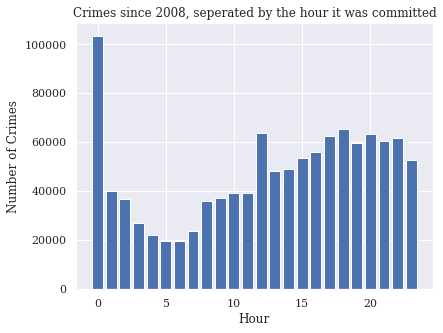

In [21]:
# Create a bar graph
plt.bar(numberCounterArray, HourSumArray)

# Add title and labels
plt.title('Crimes since 2008, seperated by the hour it was committed')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')

# Show the plot
plt.show()

In [22]:
violentCrimesArray=['Homicide','Rape','Robbery','Aggraved Assault']
violentCrime_df=date_time_df[date_time_df['Offense'].isin(violentCrimesArray)]

In [23]:
pettyTheftCrimesArray=['Theft From Building','Theft From Coin-Operated Machine or Device','Theft From Motor Vehicle', 'Thefts of Motor Vehicle Parts or Accessories','Shoplifting','Pocket-picking','Stolen Property Offenses','All Other Larceny','Purse-snatching']
pettyPropertyCrimesArray=['Destruction/Damage/Vandalism of Property','Trespass of Real Property']
pettyCrimesArray=['Curfew/Loitering/Vagrancy Violations']
pettyScaryCrimesArray=['Drug Equipment Violations','Drug/Narcotic Violations','Drunkness','Kidnapping/Abduction','Weapon Violation Laws']
pettyViolentCrimesArray=['Intimidation','Simple Assault']
#propertyCrimesArray=['Arson','Burglary','Larceny-Theft','Motor Vehicle Theft']


In [24]:
violentCrime_HourSumArray=np.arange(24)
for i in range(24):
    violentCrime_HourSumArray[i] = (violentCrime_df['Hour'] == i).sum()

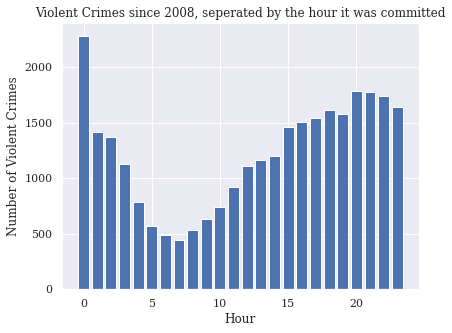

In [25]:
# Create a bar graph
plt.bar(numberCounterArray, violentCrime_HourSumArray)

# Add title and labels
plt.title('Violent Crimes since 2008, seperated by the hour it was committed')
plt.xlabel('Hour')
plt.ylabel('Number of Violent Crimes')

# Show the plot
plt.show()

In [26]:
propertyCrimesArray=['Arson','Burglary','Larceny-Theft','Motor Vehicle Theft']
propertyCrime_df=date_time_df[date_time_df['Offense'].isin(propertyCrimesArray)]

In [27]:
propertyCrime_HourSumArray=np.arange(24)
for i in range(24):
    propertyCrime_HourSumArray[i] = (propertyCrime_df['Hour'] == i).sum()

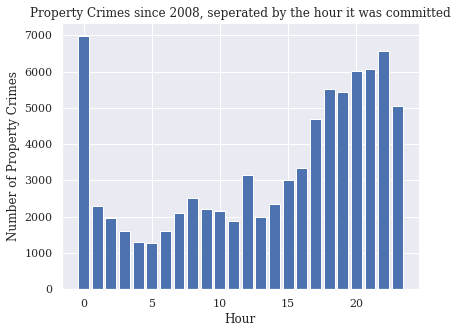

In [28]:
# Create a bar graph
plt.bar(numberCounterArray, propertyCrime_HourSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the hour it was committed')
plt.xlabel('Hour')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

In [29]:
monthCounterArray=np.arange(13)
aggregateCrime_MonthSumArray=np.arange(13)
violentCrime_MonthSumArray=np.arange(13)
propertyCrime_MonthSumArray=np.arange(13)
for i in range(13):
    propertyCrime_MonthSumArray[i] = (propertyCrime_df['Month'] == i).sum()
    aggregateCrime_MonthSumArray[i]=(date_time_df['Month']==i).sum()
    violentCrime_MonthSumArray[i]=(violentCrime_df['Month']==i).sum()

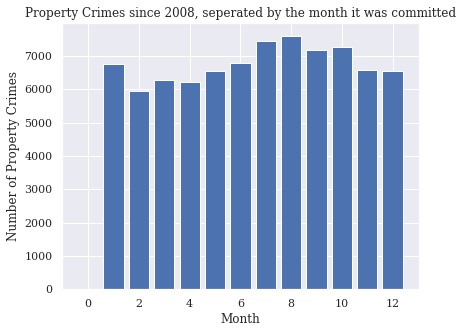

In [30]:
# Create a bar graph
plt.bar(monthCounterArray, propertyCrime_MonthSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the month it was committed')
plt.xlabel('Month')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

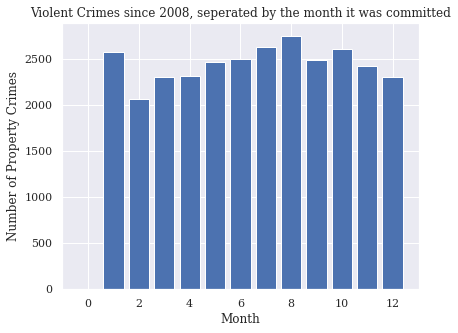

In [31]:
# Create a bar graph
plt.bar(monthCounterArray, violentCrime_MonthSumArray)

# Add title and labels
plt.title('Violent Crimes since 2008, seperated by the month it was committed')
plt.xlabel('Month')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

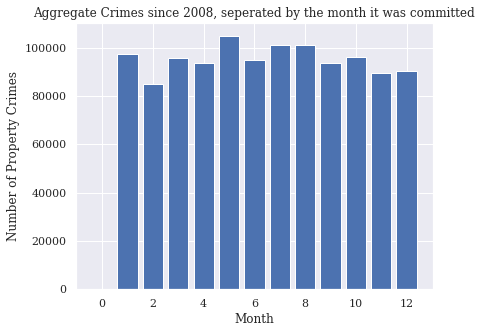

In [32]:
# Create a bar graph
plt.bar(monthCounterArray, aggregateCrime_MonthSumArray)

# Add title and labels
plt.title('Aggregate Crimes since 2008, seperated by the month it was committed')
plt.xlabel('Month')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

In [33]:
yearCounterArray=np.arange(18)
aggregateCrime_YearSumArray=np.arange(18)
violentCrime_YearSumArray=np.arange(18)
propertyCrime_YearSumArray=np.arange(18)
for i in range(17):
    yearCounterArray[i]=i+2007
    propertyCrime_YearSumArray[i] = (propertyCrime_df['Year'] ==yearCounterArray[i]).count()
    aggregateCrime_YearSumArray[i]=(date_time_df['Year']==yearCounterArray[i]).count()
    violentCrime_YearSumArray[i]=(violentCrime_df['Year']==yearCounterArray[i]).count()

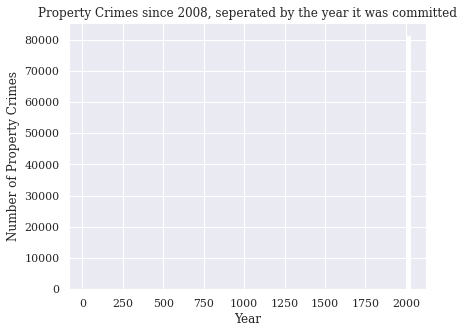

In [34]:
# Create a bar graph
plt.bar(yearCounterArray, propertyCrime_YearSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the year it was committed')
plt.xlabel('Year')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

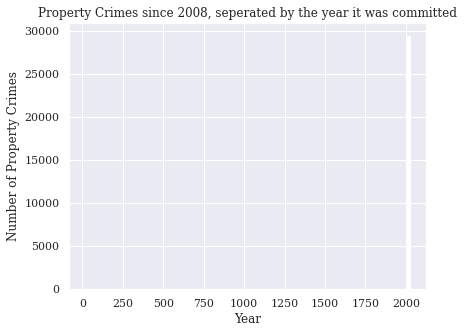

In [35]:
# Create a bar graph
plt.bar(yearCounterArray, violentCrime_YearSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the year it was committed')
plt.xlabel('Year')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

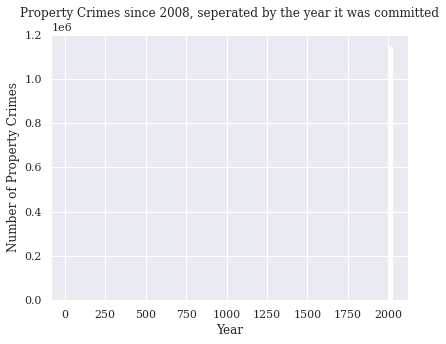

In [36]:
# Create a bar graph
plt.bar(yearCounterArray, aggregateCrime_YearSumArray)

# Add title and labels
plt.title('Property Crimes since 2008, seperated by the year it was committed')
plt.xlabel('Year')
plt.ylabel('Number of Property Crimes')

# Show the plot
plt.show()

In [37]:
#MCPP filters
MCPPFilter=['Bitterlake','Queen Anne','Northgate','Pioneer Square','Ballard South','Belltown','Downtown Commercial','First Hill','Chinatown/International District']
MCPPFilterCondition=date_time_df['MCPP'].isin(MCPPFilter)
#Precinct filters
PrecinctFilter=['E','W','N']
PrecinctFilterCondition=date_time_df['Precinct'].isin(PrecinctFilter)
#beat filters
BeatFilter=['K3','E3','D3','D1','M1','K1','B1','B3','N2','Q3']
BeatFilterCondition=date_time_df['Beat'].isin(BeatFilter)
#sector filters
SectorFilter=['N','Q','K','B','D','M','E']
SectorFilterCondition=date_time_df['Sector'].isin(SectorFilter)


In [165]:
txtfile=open("C:/Users/NGong/OneDrive - Eastside Preparatory School/Documents/IS stuff/toftTerrace.txt","r")
with txtfile as file:
    lines=file.readlines()
startFilter=lines[0]
startFilter = startFilter[:-1]
endFilter=lines[1]
endFilter = endFilter[:-1]
latitude=lines[2]
latitude=latitude[:-1]
longitude=lines[3]
longitude=longitude[:-1]
HundredsMeterRadius=lines[4]
timeFrequency=lines[5]
timeFrequency=timeFrequency[:-1]
crimeType=lines[6]
crimeType = crimeType[:-1]
startFilter=pd.to_datetime(startFilter)
endFilter=pd.to_datetime(endFilter)
latitude=float(latitude)
longitude=float(longitude)
HundredsMeterRadius=int(HundredsMeterRadius)
timeFrequency=str(timeFrequency)
print(lines)

['2021-01-01\n', '2024-01-01\n', '47.675510\n', '-122.375820\n', '5\n', 'month\n', 'aggregate\n', 'Toft Terrace']


In [166]:
date_time_df['Violent Crimes']=date_time_df['Offense'].where(date_time_df['Offense'].isin(violentCrimesArray))
date_time_df['Property Crime']=date_time_df['Offense'].where(date_time_df['Offense'].isin(propertyCrimesArray))
date_time_df['Petty Crime']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyCrimesArray))
date_time_df['Petty Property Crime']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyPropertyCrimesArray))
date_time_df['Petty Scary Crime']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyScaryCrimesArray))
date_time_df['Petty Theft Crime']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyTheftCrimesArray))
date_time_df['Petty Violent Crime']=date_time_df['Offense'].where(date_time_df['Offense'].isin(pettyViolentCrimesArray))

In [167]:
filteredTime_df=date_time_df[(date_time_df['Offense Start DateTime'] >= startFilter) & (date_time_df['Offense End DateTime'] <= endFilter)]
LocationLatitudeCondition=(date_time_df['Latitude']>=latitude-HundredsMeterRadius/2882) & (date_time_df['Latitude']<=latitude+HundredsMeterRadius/2882)
LocationLongitudeCondition=(date_time_df['Longitude']>=longitude-HundredsMeterRadius/2882) & (date_time_df['Longitude']<=longitude+HundredsMeterRadius/2882)
LocationCondition=LocationLatitudeCondition&LocationLongitudeCondition
LocationTime_df=filteredTime_df[LocationCondition]
print(LocationTime_df)

        Precinct Sector Beat           MCPP Offense Start DateTime   
853391         N      B   B1  BALLARD SOUTH    2021-04-06 14:34:00  \
854345         N      B   B1  BALLARD SOUTH    2021-04-21 00:00:00   
855248         N      B   B1  BALLARD SOUTH    2021-04-29 00:00:00   
857289         N      B   B1  BALLARD SOUTH    2021-05-14 12:30:00   
858128         N      J   J2  BALLARD NORTH    2021-05-19 08:00:00   
...          ...    ...  ...            ...                    ...   
1090071        N      B   B1  BALLARD SOUTH    2023-12-01 00:00:00   
1090091        N      B   B1  BALLARD SOUTH    2023-11-26 13:35:00   
1095691        N      J   J2  BALLARD NORTH    2023-12-28 18:10:00   
1096974        N      B   B1  BALLARD SOUTH    2023-12-11 10:30:00   
1096975        N      B   B1  BALLARD SOUTH    2023-12-11 10:30:00   

        Offense End DateTime     Report DateTime   
853391   2021-04-06 21:00:00 2021-04-13 07:05:04  \
854345   2021-04-21 00:00:00 2021-04-23 13:59:19   
855

In [182]:
# Create a new column for month-year for grouping
if timeFrequency=="month":
    print('JAI SHARMA')
    LocationTime_df['month_year'] = LocationTime_df['Offense Start DateTime'].dt.to_period('M')
    print('super cool')
    print(LocationTime_df)
if timeFrequency=="year":
    LocationTime_df['month_year'] = LocationTime_df['Offense Start DateTime'].dt.to_period('Y')
if timeFrequency=="day":
    LocationTime_df['month_year'] = LocationTime_df['Offense Start DateTime'].dt.to_period('D')
else:
    print('womp womp')



# Group by month-year and calculate the sum (or mean, count, etc.) of the values
if crimeType=='violent':
    print('violent')
    LocationTime_df=LocationTime_df.dropna(subset=["Violent Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Violent Crimes')
if crimeType=='property': 
    print('property')   
    LocationTime_df=LocationTime_df.dropna(subset=["Property Crimes"])
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Property Crimes')
if crimeType=='aggregate':
    print('aggregate')
    monthly_crimes = LocationTime_df.groupby('month_year').size().reset_index(name='Offense')
print(monthly_crimes)

#making sure that time_crime does have the dropped values for months where there are no violent or property crimes
if 'month_year' in LocationTime_df.columns:
    time_crimes = LocationTime_df.groupby('month_year').size().reset_index()
    print(time_crimes.head(5))
else:
    print("The column 'month_year' does not exist.")
print(time_crimes['month_year'])
#print(monthly_crimes['month_year'])

# Convert month_year back to datetime for plotting. Note that I'm using time_crimes since monthly_crimes becomes goofy with by seperating violent, property, and aggregate offenses
time_crimes['month_year'] = time_crimes['month_year'].dt.to_timestamp()
print(type(time_crimes['month_year']))



JAI SHARMA
super cool
        Precinct Sector Beat           MCPP Offense Start DateTime   
853391         N      B   B1  BALLARD SOUTH    2021-04-06 14:34:00  \
854345         N      B   B1  BALLARD SOUTH    2021-04-21 00:00:00   
855248         N      B   B1  BALLARD SOUTH    2021-04-29 00:00:00   
857289         N      B   B1  BALLARD SOUTH    2021-05-14 12:30:00   
858128         N      J   J2  BALLARD NORTH    2021-05-19 08:00:00   
...          ...    ...  ...            ...                    ...   
1090071        N      B   B1  BALLARD SOUTH    2023-12-01 00:00:00   
1090091        N      B   B1  BALLARD SOUTH    2023-11-26 13:35:00   
1095691        N      J   J2  BALLARD NORTH    2023-12-28 18:10:00   
1096974        N      B   B1  BALLARD SOUTH    2023-12-11 10:30:00   
1096975        N      B   B1  BALLARD SOUTH    2023-12-11 10:30:00   

        Offense End DateTime     Report DateTime   
853391   2021-04-06 21:00:00 2021-04-13 07:05:04  \
854345   2021-04-21 00:00:00 2021

   month_year   0
0  2021-01-01   3
1  2021-02-01   3
2  2021-03-01   3
3  2021-04-01   8
4  2021-05-01   5
5  2021-06-01   4
6  2021-07-01   3
7  2021-08-01   3
8  2021-09-01   2
9  2021-10-01   6
10 2021-11-01   5
11 2021-12-01   3
12 2022-01-01   2
13 2022-02-01   8
14 2022-03-01   1
15 2022-04-01   1
16 2022-05-01   2
17 2022-07-01   3
18 2022-08-01   2
19 2022-09-01   3
20 2022-10-01   5
21 2022-11-01   4
22 2022-12-01   6
23 2023-01-01   4
24 2023-02-01   4
25 2023-04-01   4
26 2023-05-01   4
27 2023-06-01   3
28 2023-07-01   7
29 2023-08-01   4
30 2023-09-01   5
31 2023-10-01   4
32 2023-11-01   3
33 2023-12-01  11


TypeError: float() argument must be a string or a real number, not 'Period'

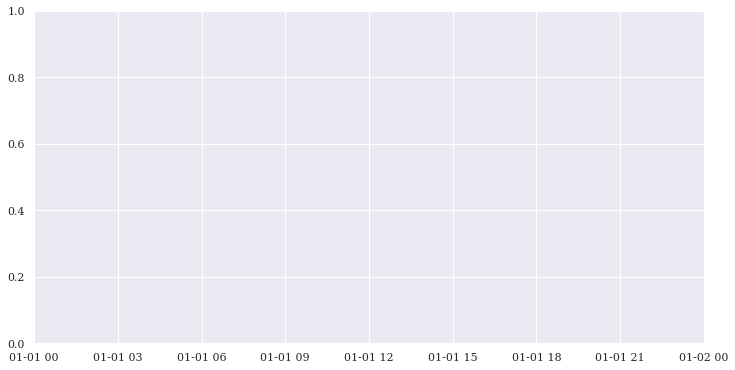

In [177]:
# Plotting
startFilter=str(startFilter)
endFilter=str(endFilter)
homelessShelterName=lines[7]
plt.figure(figsize=(12, 6))
plt.plot(time_crimes['month_year'], monthly_crimes, marker='o')
plt.title('Data of crime between in '+homelessShelterName+' '+startFilter+'to' +endFilter)
plt.xlabel('Month')
plt.ylabel('Sum of ' +crimeType + 'Crime')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [41]:
#creating time filters for each of the homeless shelters - starts with Toft Terrace
yearstofilter=[2021,2022,2023,2024]
toftTerraceYearCondition=date_time_df['Year'].isin(yearstofilter)
toftTerraceMonthStartCondition=date_time_df['Month']='January'
toftTerraceMCPPCondition=date_time_df['MCPP']='Ballard South'
toftTerracePrecinctCondition=date_time_df['Precinct']='N'
toftTerraceBeatCondition=date_time_df['Beat']='B1'
toftTerraceSectorCondition=date_time_df['Sector']='B'

toftTerrace100LocationLatitudeCondition=(date_time_df['Latitude']>=47.675510-1/2882) & (date_time_df['Latitude']<=47.675510+1/2882)
toftTerrace100LocationLongitudeCondition=(date_time_df['Longitude']>=-122.375820-1/2882) & (date_time_df['Longitude']<=-122.375820+1/2882)
toftTerrace100LocationCondition=toftTerrace100LocationLatitudeCondition&toftTerrace100LocationLongitudeCondition
toftTerraceYear_df=date_time_df[toftTerraceYearCondition]
toftTerraceLocationTime_df=toftTerraceYear_df[toftTerrace100LocationCondition]
#pd.concat, and using location of each latitude and brute-compare with this value
#pd.merge, gets all the remaining values

In [42]:
#creating time filters for each of the homeless shelters - Bob G
yearstofilter=[2019,2020,2021,2022,2023]
BobGYearCondition=date_time_df['Year'].isin(yearstofilter)
BobGMonthStartCondition=date_time_df['Month']='June'
BobGMCPPCondition=date_time_df['MCPP']='Queen Anne'
BobGPrecinctCondition=date_time_df['Precinct']='W'
BobGBeatCondition=date_time_df['Beat']='Q3'
BobGSectorCondition=date_time_df['Sector']='Q'
BobG100LocationCondition=(date_time_df['Latitude']>=47.623510-1/2882) & (date_time_df['Latitude']<=47.623510+1/2882) & (date_time_df['Longitude']>=-122.355790-1/2882) & (date_time_df['Longitude']<=-122.355790+1/2882)
BobG_df=date_time_df[BobGYearCondition & BobG100LocationCondition]



In [43]:
#creating time filters for each of the homeless shelters - Mary Pilgrim Inn
yearstofilter=[2019,2020,2021,2022,2023]
MaryPilgrimYearCondition=date_time_df['Year'].isin(yearstofilter)
MaryPilgrimMonthStartCondition=date_time_df['Month']='October'
MaryPilgrimMCPPCondition=date_time_df['MCPP']='Queen Anne'
MaryPilgrimPrecinctCondition=date_time_df['Precinct']='N'
MaryPilgrimBeatCondition=date_time_df['Beat']='N2'
MaryPilgrimSectorCondition=date_time_df['Sector']='N'
MaryPilgrim100LocationCondition=(date_time_df['Latitude']>=47.731380-1/2882) & (date_time_df['Latitude']<=47.731380+1/2882) & (date_time_df['Longitude']>=-122.345551-1/2882) & (date_time_df['Longitude']<=-122.345551+1/2882)
MaryPilgrim_df=date_time_df[MaryPilgrimYearCondition & MaryPilgrim100LocationCondition]


In [44]:
#creating time filters for each of the homeless shelters - Gateway
yearstofilter=[2020,2021,2022,2023,2024]
GatewayYearCondition=date_time_df['Year'].isin(yearstofilter)
GatewayMonthStartCondition=date_time_df['Month']='June'
GatewayMCPPCondition=date_time_df['MCPP']='Northgate'
GatewayPrecinctCondition=date_time_df['Precinct']='N'
GatewayBeatCondition=date_time_df['Beat']='N2'
GatewaySectorCondition=date_time_df['Sector']='N'
Gateway100LocationCondition=(date_time_df['Latitude']>=47.725250-1/2882) & (date_time_df['Latitude']<=47.725250+1/2882) & (date_time_df['Longitude']>=-122.341621-1/2882) & (date_time_df['Longitude']<=-122.341621+1/2882)
Gateway_df=date_time_df[GatewayYearCondition & Gateway100LocationCondition]


In [45]:
#creating time filters for each of the homeless shelters - Salmonberry Lofts
yearstofilter=[2021,2022,2023,2024]
SalmonberryLoftsYearCondition=date_time_df['Year'].isin(yearstofilter)
SalmonberryLoftsMonthStartCondition=date_time_df['Month']='February'
SalmonberryLoftsMCPPCondition=date_time_df['MCPP']='Pioneer Square'
SalmonberryLoftsPrecinctCondition=date_time_df['Precinct']='W'
SalmonberryLoftsBeatCondition=date_time_df['Beat']='K3'
SalmonberryLoftsSectorCondition=date_time_df['Sector']='K'
SalmonberryLofts100LocationCondition=(date_time_df['Latitude']>=47.623510-1/2882) & (date_time_df['Latitude']<=47.623510+1/2882) & (date_time_df['Longitude']>=-122.330770-1/2882) & (date_time_df['Longitude']<=-122.330770+1/2882)
SalmonberryLofts_df=date_time_df[SalmonberryLoftsYearCondition & SalmonberryLofts100LocationCondition]


In [46]:
#creating time filters for each of the homeless shelters - Sylvia Odom's place
yearstofilter=[2014,2015,2016,2017,2018]
SylviaOdomYearCondition=date_time_df['Year'].isin(yearstofilter)
SylviaOdomMonthStartCondition=date_time_df['Month']='February'
SylviaOdomMCPPCondition=date_time_df['MCPP']='Belltown'
SylviaOdomPrecinctCondition=date_time_df['Precinct']='W'
SylviaOdomBeatCondition=date_time_df['Beat']='M1'
SylviaOdomSectorCondition=date_time_df['Sector']='M'
SylviaOdom100LocationCondition=(date_time_df['Latitude']>=47.612550-1/2882) & (date_time_df['Latitude']<=47.612550+1/2882) & (date_time_df['Longitude']>=-122.34176-1/2882) & (date_time_df['Longitude']<=-122.34176+1/2882)
SylviaOdom_df=date_time_df[SylviaOdomYearCondition & SylviaOdom100LocationCondition]


In [47]:
#creating time filters for each of the homeless shelters - Scargo
yearstofilter=[2021,2022,2023,2024]
ScarGoYearCondition=date_time_df['Year'].isin(yearstofilter)
ScarGoMonthStartCondition=date_time_df['Month']='January'
ScarGoMCPPCondition=date_time_df['MCPP']='Belltown'
ScarGoPrecinctCondition=date_time_df['Precinct']='W'
ScarGoBeatCondition=date_time_df['Beat']='M1'
ScarGoSectorCondition=date_time_df['Sector']='M'
ScarGo100LocationCondition=(date_time_df['Latitude']>=47.612670-1/2882) & (date_time_df['Latitude']<=47.612670+1/2882) & (date_time_df['Longitude']>=-122.345900-1/2882) & (date_time_df['Longitude']<=-122.345900+1/2882)
ScarGo_df=date_time_df[ScarGoYearCondition & ScarGo100LocationCondition]


In [48]:
#creating time filters for each of the homeless shelters - Plymouth Place
PlymouthPlaceMCPPCondition=date_time_df['MCPP']='Belltown'
PlymouthPlacePrecinctCondition=date_time_df['Precinct']='W'
PlymouthPlaceBeatCondition=date_time_df['Beat']='D1'
PlymouthPlaceSectorCondition=date_time_df['Sector']='D'
PlymouthPlace100LocationCondition=(date_time_df['Latitude']>=47.618330-1/2882) & (date_time_df['Latitude']<=47.618330+1/2882) & (date_time_df['Longitude']>=-122.355560-1/2882) & (date_time_df['Longitude']<=-122.355560+1/2882)
PlymouthPlace_df=date_time_df[PlymouthPlace100LocationCondition]


In [49]:
#creating time filters for each of the homeless shelters - Plymouth on Stewart
PlymouthStewartMCPPCondition=date_time_df['MCPP']='Belltown'
PlymouthStewartPrecinctCondition=date_time_df['Precinct']='W'
PlymouthStewartBeatCondition=date_time_df['Beat']='M1'
PlymouthStewartSectorCondition=date_time_df['Sector']='M'
PlymouthStewart100LocationCondition=(date_time_df['Latitude']>=47.610870-1/2882) & (date_time_df['Latitude']<=47.610870+1/2882) & (date_time_df['Longitude']>=-122.340910-1/2882) & (date_time_df['Longitude']<=-122.340910+1/2882)
PlymouthPlace_df=date_time_df[PlymouthStewart100LocationCondition]


In [50]:
#creating time filters for each of the homeless shelters - Plymouth on First Hill
yearstofilter=[2015,2016,2017,2018,2019]
PlymouthYearCondition=date_time_df['Year'].isin(yearstofilter)
PlymouthFirstMonthStartCondition=date_time_df['Month']='September'
PlymouthFirstMCPPCondition=date_time_df['MCPP']='Belltown'
PlymouthFirstPrecinctCondition=date_time_df['Precinct']='W'
PlymouthFirstBeatCondition=date_time_df['Beat']='M1'
PlymouthFirstSectorCondition=date_time_df['Sector']='M'
PlymouthFirst100LocationCondition=(date_time_df['Latitude']>=47.605620-1/2882) & (date_time_df['Latitude']<=47.605620+1/2882) & (date_time_df['Longitude']>=-122.327440-1/2882) & (date_time_df['Longitude']<=-122.327440+1/2882)
Plymouth_time_df=date_time_df[PlymouthYearCondition]
PlymouthFirst_df=date_time_df[PlymouthFirst100LocationCondition]


In [51]:
#creating time filters for each of the homeless shelters - starts with Pacific Apartments
PacificApartmentsMCPPCondition=date_time_df['MCPP']='Downtown Commercial'
PacificApartmentsPrecinctCondition=date_time_df['Precinct']='W'
PacificApartmentsBeatCondition=date_time_df['Beat']='K1'
PacificApartmentsSectorCondition=date_time_df['Sector']='K'

PacificApartments100LocationLatitudeCondition=(date_time_df['Latitude']>=47.605020-1/2882) & (date_time_df['Latitude']<=47.605020+1/2882)
PacificApartments100LocationLongitudeCondition=(date_time_df['Longitude']>=-122.332390-1/2882) & (date_time_df['Longitude']<=-122.332390+1/2882)
PacificApartments100LocationCondition=PacificApartments100LocationLatitudeCondition&PacificApartments100LocationLongitudeCondition
PacificApartmentsLocation_df=date_time_df[PacificApartments100LocationCondition]
#pd.concat, and using location of each latitude and brute-compare with this value
#pd.merge, gets all the remaining values

In [52]:
#creating time filters for each of the homeless shelters - starts with Bob Marcia and Almquist Place
yearstofilter=[2018,2019,2020,2021,2022]
BobMarciaYearCondition=date_time_df['Year'].isin(yearstofilter)
BobMarciaMonthStartCondition=date_time_df['Month']='April'
BobMarciaMCPPCondition=date_time_df['MCPP']='Chinatown/International District'
BobMarciaPrecinctCondition=date_time_df['Precinct']='W'
BobMarciaBeatCondition=date_time_df['Beat']='K3'
BobMarciaSectorCondition=date_time_df['Sector']='K'
BobMarcia100LocationLatitudeCondition=(date_time_df['Latitude']>=47.598160-1/2882) & (date_time_df['Latitude']<=47.598160+1/2882)
BobMarcia100LocationLongitudeCondition=(date_time_df['Longitude']>=-122.313660-1/2882) & (date_time_df['Longitude']<=-122.313660+1/2882)
BobMarcia100LocationCondition=BobMarcia100LocationLatitudeCondition&BobMarcia100LocationLongitudeCondition
BobMarciaYear_df=date_time_df[BobMarciaYearCondition]
BobMarciaLocationTime_df=BobMarciaYear_df[BobMarcia100LocationCondition]
#pd.concat, and using location of each latitude and brute-compare with this value
#pd.merge, gets all the remaining values

In [53]:
#creating time filters for each of the homeless shelters - starts with Blake House
yearstofilter=[2021,2022,2023,2024]
BlakeHouseYearCondition=date_time_df['Year'].isin(yearstofilter)
BlakeHouseMonthStartCondition=date_time_df['Month']='April'
BlakeHouseMCPPCondition=date_time_df['MCPP']='Capitol Hill'
BlakeHousePrecinctCondition=date_time_df['Precinct']='E'
BlakeHouseBeatCondition=date_time_df['Beat']='E3'
BlakeHouseSectorCondition=date_time_df['Sector']='E'
BlakeHouse100LocationLatitudeCondition=(date_time_df['Latitude']>=47.611230-1/2882) & (date_time_df['Latitude']<=47.611230+1/2882)
BlakeHouse100LocationLongitudeCondition=(date_time_df['Longitude']>=-122.322010-1/2882) & (date_time_df['Longitude']<=-122.322010+1/2882)
BlakeHouse100LocationCondition=BlakeHouse100LocationLatitudeCondition&BlakeHouse100LocationLongitudeCondition
BlakeHouseYear_df=date_time_df[BlakeHouseYearCondition]
BlakeHouseLocationTime_df=BlakeHouseYear_df[BlakeHouse100LocationCondition]


In [55]:
#creating time filters for each of the homeless shelters - starts with AL Humphrey House
yearstofilter=[2008,2009,2010,2011,2012]
ALHouseYearCondition=date_time_df['Year'].isin(yearstofilter)
ALHouseMonthStartCondition=date_time_df['Month']='July'
ALHouseMCPPCondition=date_time_df['MCPP']='Belltown'
ALHousePrecinctCondition=date_time_df['Precinct']='W'
ALHouseBeatCondition=date_time_df['Beat']='D1'
ALHouseSectorCondition=date_time_df['Sector']='D'
ALHouse100LocationLatitudeCondition=(date_time_df['Latitude']>=47.611230-1/2882) & (date_time_df['Latitude']<=47.611230+1/2882)
ALHouse100LocationLongitudeCondition=(date_time_df['Longitude']>=-122.322010-1/2882) & (date_time_df['Longitude']<=-122.322010+1/2882)
ALHouse100LocationCondition=ALHouse100LocationLatitudeCondition&ALHouse100LocationLongitudeCondition
ALHouseYear_df=date_time_df[ALHouseYearCondition]
ALHouseLocationTime_df=ALHouseYear_df[ALHouse100LocationCondition]


In [ ]:
print(date_time_df['Longitude'].head())